In [1]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
# 特徴量のリスト
features = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
    "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# データの読み込み
data = pd.read_csv('NSL-KDD/KDDTrain+.txt', sep=',', header=None, names=features)
target = data['label'].copy()
data.drop(["service", "land", "protocol_type", "flag", "is_host_login", "logged_in", "is_guest_login", "label", "difficulty"], axis=1, inplace=True)

# ラベルの置換
# 正常: 0, 攻撃: 1
target[target != 'normal'] = 1
target[target == 'normal'] = 0

# データの確認
#print(data.head())
#print(target.head())
print(target.value_counts())
#print(target.shape)
#print(f"Data shape: {data.shape}")
#print(f"Columns: {data.columns}")


label
0    67343
1    58630
Name: count, dtype: int64


In [3]:
# trainデータを分割して学習データとテストデータに分ける
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

# ラベルの型をintに変換
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# インデックスをリセット
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

data_train = X_train
target_train = y_train
data_test = X_test
target_test = y_test

# データの確認
print(f"data_train shape is : {data_train.shape}")
print(f"data_test shape is : {data_test.shape}")
#print(data_train.head())
#print(data_test.head())

data_train shape is : (88181, 34)
data_test shape is : (37792, 34)


accuracy_score is : 0.998174216765453


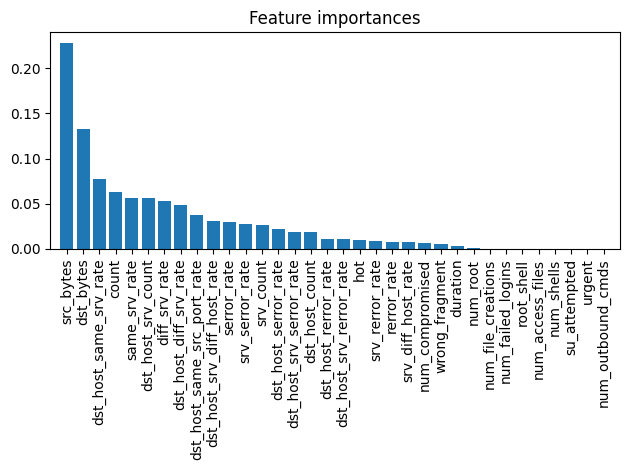

In [4]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# モデルの作成
model = RandomForestClassifier(n_estimators=100, random_state=42)

# モデルの学習
model.fit(data_train, target_train)

# モデルの評価
predict = model.predict(data_test)
print(f"accuracy_score is : {accuracy_score(target_test, predict)}")

# 重要な特徴量の可視化
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(data_train.shape[1]), importances[indices], align='center')
plt.xticks(range(data_train.shape[1]), data_train.columns[indices], rotation=90)
plt.xlim([-1, data_train.shape[1]])
plt.tight_layout()
plt.show()


In [5]:
# iforestで異常検知
from sklearn.ensemble import IsolationForest

# データを正常と異常に分割
data_train_normal = data_train[target_train == 0] # 0がnormal
data_train_anomaly = data_train[target_train == 1]  # 1がanomaly

# 特徴量の選択
important_features = data_train.columns[importances > 0.03]

data_train_normal_dropped = data_train_normal[important_features]
data_train_anomaly_dropped = data_train_anomaly[important_features]
data_test_dropped = data_test[important_features]

# モデルの作成
model_normal = IsolationForest(contamination=0.1, random_state=42)
model_anomaly = IsolationForest(contamination=0.1, random_state=42)

# モデルの学習
model_normal.fit(data_train_normal_dropped)
model_anomaly.fit(data_train_anomaly_dropped)

# モデルの評価
predict_normal = model_normal.predict(data_test_dropped)
predict_normal = np.where(predict_normal == 1, 0, 1) # 1が正常になるように変換
predict_anomaly = model_anomaly.predict(data_test_dropped)
predict_anomaly = np.where(predict_anomaly == 1, 1, 0) # 1が異常になるように変換

# 結果の確認
results = {
    "data_train_normal_dropped shape": data_train_normal_dropped.shape,
    "data_train_anomaly_dropped shape": data_train_anomaly_dropped.shape,
    "data_test_dropped shape": data_test_dropped.shape,
    "accuracy_score_normal": accuracy_score(target_test, predict_normal),
    "accuracy_score_anomaly": accuracy_score(target_test, predict_anomaly),
    "predict_normal value count": pd.Series(predict_normal).value_counts().to_dict(),
    "predict_anomaly value count": pd.Series(predict_anomaly).value_counts().to_dict(),
}

for key, value in results.items():
    print(f"{key}:\n{value}\n")


data_train_normal_dropped shape:
(47182, 10)

data_train_anomaly_dropped shape:
(40999, 10)

data_test_dropped shape:
(37792, 10)

accuracy_score_normal:
0.9094517358171041

accuracy_score_anomaly:
0.8475867908552075

predict_normal value count:
{0: 19407, 1: 18385}

predict_anomaly value count:
{1: 19869, 0: 17923}



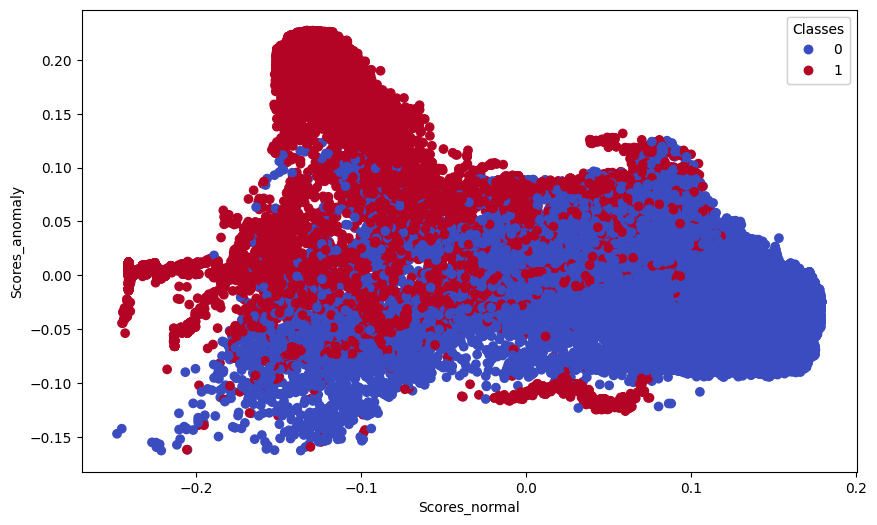

In [6]:
# trainデータのアノマリスコアの確認
data_train_dropped = data_train[important_features]
scores_normal_train = model_normal.decision_function(data_train_dropped)
scores_anomaly_train = model_anomaly.decision_function(data_train_dropped)
scores_train = np.column_stack((scores_normal_train, scores_anomaly_train))

# プロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores_train[:, 0], scores_train[:, 1], c=target_train, cmap='coolwarm')
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()

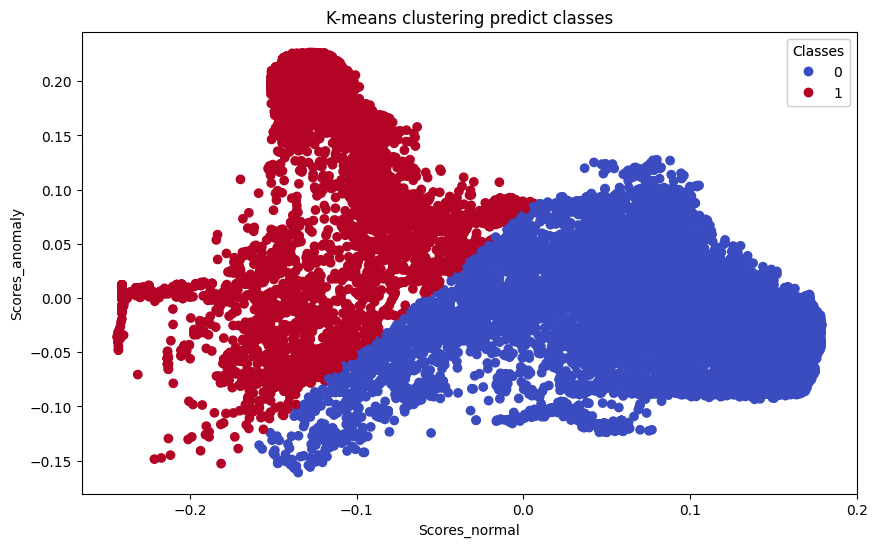

accuracy_score is : 0.9165167231160034


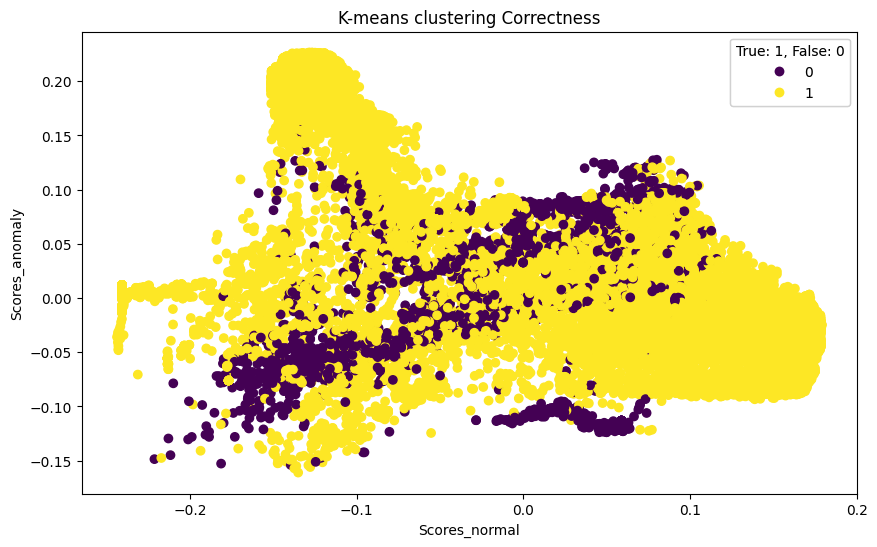

In [7]:
# testデータのアノマリスコアの確認
scores_normal_test = model_normal.decision_function(data_test_dropped)
scores_anomaly_test = model_anomaly.decision_function(data_test_dropped)
scores = np.column_stack((scores_normal_test, scores_anomaly_test))

# K-meansでクラスタリング
from sklearn.cluster import KMeans
initial_centers = np.array([[1, -1], [-1, 1]])
model = KMeans(n_clusters=2, init=initial_centers, n_init=1)
y_pred = model.fit_predict(scores)
labels = np.where(y_pred == target_test, 1, 0)  # true: 1, false: 0

# 予測結果のプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=y_pred, cmap='coolwarm')
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("K-means clustering predict classes")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()

#　精度の確認
print(f"accuracy_score is : {accuracy_score(target_test, y_pred)}")

# ラベルをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=labels, cmap="viridis")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("K-means clustering Correctness")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True: 1, False: 0")
plt.gca().add_artist(legend1)
plt.show()


y_pred: [0 0 0 ... 0 1 0]
Accuracy: 0.9240050804403048


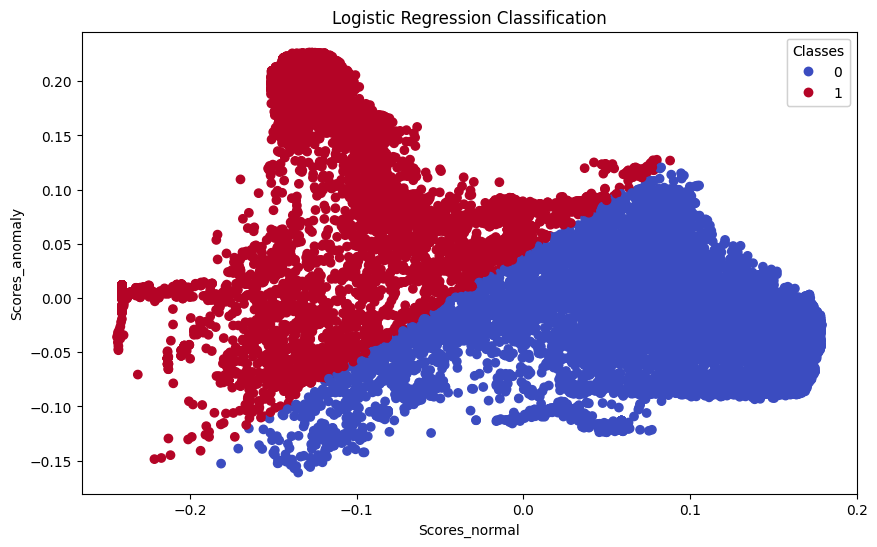

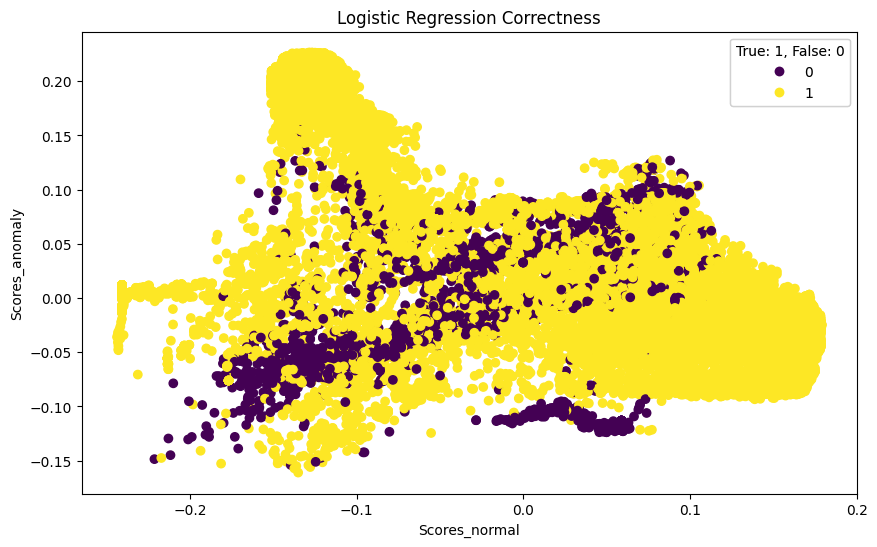

In [8]:
# ロジスティック回帰を用いてラベルを予測
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルの作成
model_LR = LogisticRegression()
model_LR.fit(scores_train, target_train)

# ラベルの予測
y_pred = model_LR.predict(scores)
print(f"y_pred: {y_pred}")
print(f"Accuracy: {accuracy_score(target_test, y_pred)}")

# ラベルをプロット
plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=y_pred, cmap="coolwarm")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("Logistic Regression Classification")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
plt.gca().add_artist(legend1)
plt.show()

# 正答率をプロット
labels = np.where(target_test == y_pred, 1, 0) # 1: 正解, 0: 不正解

plt.figure(figsize=(10, 6))
scatter = plt.scatter(scores[:, 0], scores[:, 1], c=labels, cmap="viridis")
plt.xlabel("Scores_normal")
plt.ylabel("Scores_anomaly")
plt.title("Logistic Regression Correctness")
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="True: 1, False: 0")
plt.gca().add_artist(legend1)
plt.show()
